In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
from tqdm import tqdm
import time
import concurrent.futures
from functools import partial
import itertools
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import json
10.0 ** -np.arange(1, 5)

array([0.1  , 0.01 , 0.001])

In [9]:
mydateparse = lambda dt: pd.to_datetime(dt,format='%Y-%m-%d')

In [3]:
# Train Data
train_df = pd.read_csv('train.csv',parse_dates=['Date'],
                      date_parser=mydateparse)

# Test Data
test_df = pd.read_csv('test.csv',parse_dates=['Date'],
                     date_parser=mydateparse)

# Store Data
store_df = pd.read_csv('store.csv')

#store_states Data
df_store_states = pd.read_csv("store_states.csv")

Note : I found that many ML Algorithm does not support RMSPE as Objective function. Thus as work around; we transform Sales using **Log1p**.

Reference:  <a>https://www.kaggle.com/c/rossmann-store-sales/discussion/17026</a>

<h2> Converting Sales to SalesLog </h2>

In [4]:
train_df["SalesLog"] = np.log1p(train_df['Sales']) # np.log(train_df['Sales']+1)

In [5]:
# Join both tables train_df and store_data
df = pd.merge(train_df,store_df,how='left',on='Store')

# Add the State 
df = pd.merge(df,df_store_states, how='left', on='Store')

<h2> Outlier Column based on Mean Absolute Deviation </h2>

In [6]:
# Reference : https://medium.com/@joaopedroferrazrodrigues/outliers-make-us-go-mad-univariate-outlier-detection-b3a72f1ea8c7

def mad_based_outlier(points,threshold=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points,axis=0)
   # print("Median",median)
    diff = np.sum((points-median)**2,axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    # 0.6745 is 75th percentile of Standard Normal Distribution
    # 3.5 is thumb rule for cut-off
    
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > threshold

In [7]:
# creating new colum with name "outlier" where a point is outlier or not
for i in df['Store'].unique():
    #print("Store : ",i)
    df.loc[(df['Store']==i) & (df['Open']==1), "Outlier"] = \
    mad_based_outlier(df.loc[(df.Store==i) & (df.Open == 1)]['Sales'],3.5)

# Feature Engineering 

<h2> Data features </h2>

In [8]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.weekofyear
df['DayOfYear'] = df['Date'].dt.dayofyear

<h3> Holidays this week, last week and next week.</h3>

In [9]:
store_holiday_dict = dict()

In [86]:
for j in tqdm(df['Store'].unique()):
    
    tmp_df = df.loc[df['Store']==j]
    tmp_df.sort_values(['Date'],inplace=True)
    
    holiday_last_week, holiday_this_week,holiday_next_week = [ ], [ ], [ ]
    this_week_dict = dict()
    
    for i in range(len(tmp_df)):
        
        present_week = tmp_df.iloc[i]['WeekOfYear']
        present_year = tmp_df.iloc[i]['Year']
        
        df_present = tmp_df.loc[(tmp_df['WeekOfYear']==present_week) & (tmp_df['Year']==present_year) &(tmp_df['Open']==0)]
        holidays = len(df_present)
        
        if (present_year,present_week) not in this_week_dict.keys():
            this_week_dict[(present_year,present_week)] = holidays
        else:
            continue
            
    store_holiday_dict[j] = this_week_dict

100%|██████████████████████████████████████████████████████████████████████████████| 1115/1115 [13:53<00:00,  1.34it/s]


In [91]:
store_holiday_dict[1] # Store 1 Holidays

{(2013, 1): 2,
 (2013, 2): 1,
 (2013, 3): 1,
 (2013, 4): 1,
 (2013, 5): 1,
 (2013, 6): 1,
 (2013, 7): 1,
 (2013, 8): 1,
 (2013, 9): 1,
 (2013, 10): 1,
 (2013, 11): 1,
 (2013, 12): 1,
 (2013, 13): 2,
 (2013, 14): 2,
 (2013, 15): 1,
 (2013, 16): 1,
 (2013, 17): 1,
 (2013, 18): 2,
 (2013, 19): 2,
 (2013, 20): 1,
 (2013, 21): 2,
 (2013, 22): 2,
 (2013, 23): 1,
 (2013, 24): 1,
 (2013, 25): 1,
 (2013, 26): 1,
 (2013, 27): 1,
 (2013, 28): 1,
 (2013, 29): 1,
 (2013, 30): 1,
 (2013, 31): 1,
 (2013, 32): 1,
 (2013, 33): 1,
 (2013, 34): 1,
 (2013, 35): 1,
 (2013, 36): 1,
 (2013, 37): 1,
 (2013, 38): 1,
 (2013, 39): 1,
 (2013, 40): 2,
 (2013, 41): 1,
 (2013, 42): 1,
 (2013, 43): 1,
 (2013, 44): 1,
 (2013, 45): 1,
 (2013, 46): 1,
 (2013, 47): 1,
 (2013, 48): 1,
 (2013, 49): 1,
 (2013, 50): 1,
 (2013, 51): 1,
 (2013, 52): 3,
 (2014, 1): 2,
 (2014, 2): 1,
 (2014, 3): 1,
 (2014, 4): 1,
 (2014, 5): 1,
 (2014, 6): 1,
 (2014, 7): 1,
 (2014, 8): 1,
 (2014, 9): 1,
 (2014, 10): 1,
 (2014, 11): 1,
 (2014, 12

In [96]:
store_holiday_dict.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157'

In [98]:
import pickle

with open('Holidays_dict','wb') as f:
    pickle.dump(store_holiday_dict,f)

In [100]:
for j in tqdm(df['Store'].unique()):
    
    tmp_df = df.loc[df['Store']==j]
    tmp_df.sort_values(['Date'],inplace=True)
    
    holiday_last_week, holiday_this_week,holiday_next_week = [ ], [ ], [ ]
    this_week_dict = dict()
    
    for i in range(len(tmp_df)):
        
        present_week = tmp_df.iloc[i]['WeekOfYear']
        present_year = tmp_df.iloc[i]['Year']
        
        df_present = tmp_df.loc[(tmp_df['WeekOfYear']==present_week) & (tmp_df['Year']==present_year) &(tmp_df['Open']==0)]
        holidays = len(df_present)
        
        if (present_year,present_week) not in this_week_dict.keys():
            this_week_dict[(present_year,present_week)] = holidays     # this_week_dict = {(week,year)=holiday_count} ex: {(2013, 1): 2,(2013, 2): 1}
        else:
            continue
    
   
    # Adding Holiday using dict created above
    for i in range(len(tmp_df)):
        
        present_week = tmp_df.iloc[i]['WeekOfYear']
        present_year = tmp_df.iloc[i]['Year']
        
        holiday_this_week.append(this_week_dict[(present_year,present_week)])
        
        # Boundary case for past week - for last week feature
        if present_week != 1:
            past_week = present_week - 1
            past_year = present_year
        else:
            past_week = 52
            past_year = present_year - 1
            
        try:
            holiday_last_week.append(this_week_dict[(past_year,past_week)])
        except:
            holiday_last_week.append(np.nan)
            
            
        # Boundary case for future week - for next week feature
        if present_week != 52:
            future_week = present_week + 1
            future_year = present_year
        else:
            future_week = 1
            future_year =present_year + 1
            
        try:
            holiday_next_week.append(this_week_dict[future_year,future_week])
        except:
            holiday_next_week.append(np.nan)
            
    tmp_df['holiday_this_week'] = holiday_this_week
    tmp_df['holiday_last_week'] = holiday_last_week
    tmp_df['holiday_next_week'] = holiday_next_week
    
    if j == 1:
        k = tmp_df
    else:
        k = pd.concat([k,tmp_df])     

100%|██████████████████████████████████████████████████████████████████████████████| 1115/1115 [19:01<00:00,  1.02s/it]


In [102]:
# Save the dataframe to file for future use
k.to_csv("Store_holiday_df",index=False)

# State Holiday Counter

In [127]:
df = pd.read_csv("features/Store_holiday_df",parse_dates=['Date'],date_parser=mydateparse)

In [128]:
def State_Holiday_Counter(a):
    '''
    Input -> Takes the dataframe of all rows of each store
    
    Ouput -> returns 2 series which contains State_holiday_before_days and State_holiday_after_days
    
    Task  -> These function creates 2 features :  State_holiday_before_days and State_holiday_after_days
    
    '''
    a['Date'] = pd.to_datetime(a['Date'])
    a = a.sort_values("Date")
    
    list_of_store_state_holiday_before_days = [ ]
    list_of_Store_state_holiday_after_days = [ ]
    
    for j in range(len(a)):
        
        state_holiday_before_days = 0
        state_holiday_after_days  = 0
        
        #Loop to count days before a state holiday
        for l in range(j,len(a)):
            if a.iloc[l]['StateHoliday'] == '0':
                state_holiday_before_days +=1
            else:
                break
                
        list_of_store_state_holiday_before_days.append(state_holiday_before_days)
        
        #Loop to count days after a State Holiday.
        for m in range(j,0,-1):
            if a.iloc[m]['StateHoliday']=='0':
                state_holiday_after_days +=1
            else:
                break
                
        list_of_Store_state_holiday_after_days.append(state_holiday_after_days)
        
    a['State_holiday_before_days'] = list_of_store_state_holiday_before_days
    a['State_holiday_after_days']  = list_of_Store_state_holiday_after_days
    
    return a

In [129]:
list_of_individual_store_dataframe = [ ]

for i in df['Store'].unique():
    m = df.loc[df['Store']==i]
    list_of_individual_store_dataframe.append(m)

start = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
    empty_list = [ ]
    for output in executor.map(State_Holiday_Counter,list_of_individual_store_dataframe):
        empty_list.append(output)
        
        
print(f"Time taken = ",((time.time()-start)/60),"minutes")

Time taken =  177.29884477853776 minutes


In [132]:
# Save the dataframe to file for future use
sh_df = pd.concat(empty_list)
sh_df.sort_values(by=['Year','Day'],inplace=True)
sh_df.to_csv("features/state_counter_df",index=False)

# Promo and School Holiday Counter

In [133]:
dfn = pd.read_csv('features/state_counter_df',parse_dates=['Date'],
                      date_parser=mydateparse)

In [134]:
dfn['StateHoliday'].replace(0,'0',inplace=True)

In [135]:
#Reference : https://medium.com/analytics-vidhya/rossmann-store-sales-prediction-998161027abf

def promo_school_counter(df):
    
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values("Date")
    
    list_of_store_promo_before_days = [ ]
    list_of_Store_promo_after_days = [ ]
    
    list_to_store_school_holiday_before_days = [ ]
    list_to_store_school_holiday_after_days = [ ]
    
    for j in range(len(df)):
        
        before_days = 0
        after_days  = 0
        
        school_before_days = 0
        school_after_days = 0
        
        #------------------------Promo----------------------
        
        #Loop for count days before a promo
        for x in range(j,len(df)):
            if df.iloc[x]['Promo'] != 1:
                before_days += 1
            else:
                break
                
        list_of_store_promo_before_days.append(before_days)
        
        
        #Loop to count days after a Promo
        for m in range(j,0,-1):
            if df.iloc[m]['Promo'] != 1:
                after_days +=1
            else:
                break
                
        list_of_Store_promo_after_days.append(after_days)
        
        #-----------------School before and After---------------
        
        #Loop for count days before School Holiday
        for q in range(j,len(df)):
            if df.iloc[q]['SchoolHoliday'] != 1:
                school_before_days += 1
            else:
                break
                
        list_to_store_school_holiday_before_days.append(school_before_days)
        
        
        #Loop to count days after a School Holiday.
        for w in range(j,0,-1):
            if df.iloc[w]['SchoolHoliday'] != 1:
                school_after_days +=1
            else:
                break
                
        list_to_store_school_holiday_after_days.append(school_after_days)
        
        
    df['Promo_before_days'] = list_of_store_promo_before_days
    df['Promo_after_days'] = list_of_Store_promo_after_days
    
    df['School_Holiday_before_days'] = list_to_store_school_holiday_before_days
    df['School_Holiday_after_days'] = list_to_store_school_holiday_after_days
    
    return df    

In [136]:
list_of_individual_store_dataframes = []
# 1116 - unique stores
for i in range(1,1116):
    m = dfn.loc[dfn['Store']==i]
    list_of_individual_store_dataframes.append(m)

start = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:

    empty_list = []

    for i in executor.map(promo_school_counter, list_of_individual_store_dataframes):
        empty_list.append(i)

print(f'Time taken is equal to {(time.time() - start)/60} minutes.') 

Time taken is equal to 112.97431707779566 minutes.


In [138]:
n = pd.concat(empty_list)
n.sort_values(by=['Year','Day'], inplace=True)
n.to_csv('features/df_counter_data_no_zeros',index=False)

# Removing the Stores which has Sales = 0

In [349]:
df  = pd.read_csv("features/df_counter_data_no_zeros",parse_dates=['Date'],
                 date_parser=mydateparse)

In [350]:
df = df[~(df['Sales']==0)]

In [351]:
df.shape

(844338, 35)

# Feature :  Store Sales Per day

In [352]:
total_store_sales = df.groupby('Store')['Sales'].sum()
Store_open_count = df.groupby('Store')['Open'].count()


In [353]:
# Sales per day
Store_sales_per_day = total_store_sales/ Store_open_count

# Feature : Customer flow for each Store Per Day

In [354]:
Customer_store_count = df.groupby("Store")['Customers'].sum()

In [356]:
# Customer flow for each Store Per Day
customer_sales_per_day = Customer_store_count / Store_open_count

# Feature : Sales per customer per day

In [357]:
# Sales per customer per day
Sales_per_customer_per_day = Store_sales_per_day / customer_sales_per_day

In [358]:
# save it in dictionary 
sales_per_day_dict = dict(Store_sales_per_day)
customer_per_day_dict = dict(customer_sales_per_day)
sales_per_customer_per_day_dict = dict(Sales_per_customer_per_day)

In [359]:
df['SalesPerDay'] = df['Store'].map(sales_per_day_dict)
df['CustomerPerDay'] = df['Store'].map(Customer_store_count)
df['SalesPerCustomerPerDay'] = df['Store'].map(sales_per_day_dict)

In [360]:
df[['Store','SalesPerDay','CustomerPerDay','SalesPerCustomerPerDay']]

,Store,SalesPerDay,CustomerPerDay,SalesPerCustomerPerDay
1,1,4759.096031,440523,4759.096031
2,1,4759.096031,440523,4759.096031
5,1,4759.096031,440523,4759.096031
6,1,4759.096031,440523,4759.096031
7,1,4759.096031,440523,4759.096031
...,...,...,...,...
1017202,1114,20666.562500,2509542,20666.562500
1017204,1114,20666.562500,2509542,20666.562500
1017205,1115,6302.469910,337884,6302.469910
1017206,1115,6302.469910,337884,6302.469910


In [364]:
#Storing the above dictionary so that they can be used during deploying the model.
import json

with open('features/sales_per_day_dict_no_zeros', 'w') as f:
    json.dump(sales_per_day_dict, f)

with open('features/customers_per_day_dict_no_zeros', 'w') as f:
    json.dump(customer_per_day_dict, f)

with open('features/sales_per_customers_per_day_dict_no_zeros', 'w') as f:
    json.dump(sales_per_customer_per_day_dict, f)

In [374]:
# Remove customer field
del df['Customers']

In [375]:
df.sort_values("Date",inplace=True)

# Removing all the outliers and drop the outlier column 
df = df[df['Outlier']==False].drop('Outlier',axis=1)

In [376]:
df.shape

(837940, 36)

# Feature : Competition Open and Promo Open

In [377]:
# Convert Competition to Months
df['CompetitionOpen'] = 12 * (df['Year']- df['CompetitionOpenSinceYear']) + (df['Month'] - df['CompetitionOpenSinceMonth'])

# Convert Promo open to months
df['PromoOpen'] = 12 * (df['Year']- df['Promo2SinceYear']) + (df['WeekOfYear'] - df['Promo2SinceWeek']) /4.0

In [378]:
df['PromoInterval']

9216        Jan,Apr,Jul,Oct
6132       Mar,Jun,Sept,Dec
11364                   NaN
8100                    NaN
5064                    NaN
                 ...       
1014996                 NaN
1012780                 NaN
1012784                 NaN
1012860    Mar,Jun,Sept,Dec
1017208    Mar,Jun,Sept,Dec
Name: PromoInterval, Length: 837940, dtype: object

# Feature Generation Using Promo interval

In [379]:
# Split the promo interval 
promo_interval = df['PromoInterval'].str.split(",").apply(pd.Series,1)
promo_interval.columns = ['PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3']
df = df.join(promo_interval)

In [380]:
# Converting Promo-interval to numeric
month_to_num_dict = {
                    'Jan' : 1,
                    'Feb' : 2,
                    'Mar' : 3,
                    'Apr' : 4,
                    'May' : 5,
                    'Jun' : 6,
                    'Jul' : 7,
                    'Aug' : 8,
                    'Sept' : 9, 
                    'Oct' : 10,
                    'Nov' : 11,
                    'Dec' : 12,
                    'nan' : np.NaN
                    }


df['PromoInterval0'] = df['PromoInterval0'].map(month_to_num_dict)
df['PromoInterval1'] = df['PromoInterval1'].map(month_to_num_dict)
df['PromoInterval2'] = df['PromoInterval2'].map(month_to_num_dict)
df['PromoInterval3'] = df['PromoInterval3'].map(month_to_num_dict)

#Removing PromoInterval feature as no further use now.
del df['PromoInterval']

In [381]:
df[['PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3']]

,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3
9216,1.0,4.0,7.0,10.0
6132,3.0,6.0,9.0,12.0
11364,NaN,NaN,NaN,NaN
8100,NaN,NaN,NaN,NaN
5064,NaN,NaN,NaN,NaN
...,...,...,...,...
1014996,NaN,NaN,NaN,NaN
1012780,NaN,NaN,NaN,NaN
1012784,NaN,NaN,NaN,NaN
1012860,3.0,6.0,9.0,12.0


# Feature Validation and Acceleration in Sales

Variation = y - (y-1), y = sales

Acceleration = [(y-1) - (y-2)], y = sales

In [382]:
imputer = IterativeImputer(random_state=12)

variation_per_store_dict = dict()
acceleartion_per_store_dict = dict()
weekly_rolling_mean_dict = dict()
monthly_rolling_mean_dict = dict()

In [383]:
for i in tqdm(range(1,1116)):

    a = df.loc[df['Store']==i]
    a['Variation'] = a['Sales'] - a['Sales'].shift()
    a['Acceleration'] = a["Sales"].shift() - a['Sales'].shift(2)
    a['Weekly_rolling_mean'] = a['Sales'].rolling(7).mean()
    a['Monthly_rolling_mean'] = a['Sales'].rolling(30).mean()
    
    imputer.fit(a[['Variation','Acceleration','Weekly_rolling_mean','Monthly_rolling_mean']])
    imputer.transform(a[['Variation','Acceleration','Weekly_rolling_mean','Monthly_rolling_mean']])
 
    # Store result in dict for test
    variation_per_store_dict[i] = a['Variation'].median()
    acceleartion_per_store_dict[i] = a['Acceleration'].median()
    weekly_rolling_mean_dict[i] = a['Weekly_rolling_mean'].median()
    monthly_rolling_mean_dict[i] = a['Monthly_rolling_mean'].median()
    
    if i == 1:
        b = a
    else:
        b = pd.concat([a,b])

100%|██████████████████████████████████████████████████████████████████████████████| 1115/1115 [04:09<00:00,  4.47it/s]


In [385]:
with open('features/vairation_dict_no_zeros', 'w') as f:
    json.dump(variation_per_store_dict, f)

with open('features/acceleration_dict_no_zeros', 'w') as f:
    json.dump(acceleartion_per_store_dict, f)

with open('features/weekly_rolling_dict_no_zeros', 'w') as f:
    json.dump(weekly_rolling_mean_dict, f)

with open('features/monthly_rolling_dict_no_zeros', 'w') as f:
    json.dump(monthly_rolling_mean_dict, f)

In [386]:
b.sort_values(['Year','Day'],inplace=True)
b.to_csv('features/df_variation_no_zeros.csv',index=False)

In [ ]:
b.shape

# Feature : Average Sales over past quarter 

Adding past quarter same date mean and median

In [162]:
start = time.time()

b = pd.read_csv('features/df_variation_no_zeros.csv')

imp = IterativeImputer(random_state=21)

for j in tqdm(range(1,1116)):
    
    a = b.loc[b['Store']==j]
    l = [] #List to store median values.

    for i in range(len(a)):

        try:
            
            day = a.iloc[i]['Day']
            month = a.iloc[i]['Month']
            year = a.iloc[i]['Year']

            if month > 3:

                c = a.loc[(a['Day']==day) & (a['Month'] == (month-1)) & (a['Year']==year)]['Sales']
                d = a.loc[(a['Day']==day) & (a['Month'] == (month-2)) & (a['Year']==year)]['Sales']
                e = a.loc[(a['Day']==day) & (a['Month'] == (month-3)) & (a['Year']==year)]['Sales']
                l.append(np.median([c.item(),d.item(),e.item()]))

            elif month ==3 :

                c = a.loc[(a['Day']==day) & (a['Month'] == (month-1)) & (a['Year']==year)]['Sales']
                d = a.loc[(a['Day']==day) & (a['Month'] == (month-2)) & (a['Year']==year)]['Sales']
                e = a.loc[(a['Day']==day) & (a['Month'] == (12)) & (a['Year']==(year-1))]['Sales']
                l.append(np.median([c.item(),d.item(),e.item()]))

            elif month ==2:

                c = a.loc[(a['Day']==day) & (a['Month'] == (month-1)) & (a['Year']==year)]['Sales']
                d = a.loc[(a['Day']==day) & (a['Month'] == (12)) & (a['Year']==(year-1))]['Sales']
                e = a.loc[(a['Day']==day) & (a['Month'] == (11)) & (a['Year']==(year-1))]['Sales']
                l.append(np.median([c.item(),d.item(),e.item()]))

            else:

                c = a.loc[(a['Day']==day) & (a['Month'] == (12)) & (a['Year']==(year-1))]['Sales']
                d = a.loc[(a['Day']==day) & (a['Month'] == (11)) & (a['Year']==(year-1))]['Sales']
                e = a.loc[(a['Day']==day) & (a['Month'] == (10)) & (a['Year']==(year-1))]['Sales']
                l.append(np.median([c.item(),d.item(),e.item()]))

        except:
            l.append(np.NaN)
        

    a['Previous_quarter_median'] = l

    imp.fit(a[['Previous_quarter_median']])
    imp.transform(a[['Previous_quarter_median']])

    if j==1:
        k = a
    else:
        k = pd.concat([k,a])

print(f'Time taken is {(time.time() - start)/60} minutes.')

100%|████████████████████████████████████████████████████████████████████████████| 1115/1115 [1:18:11<00:00,  4.21s/it]

Time taken is 78.24384128252665 minutes.


In [163]:
list_of_individual_store_dataframes = []
for i in range(1,1116):
    j = k.loc[k['Store']==i]
    list_of_individual_store_dataframes.append(j)

# Feature : Average Sales over past 6 Months

In [164]:
def half_year(z): #Here z is a dataframe of an individual store.

    b = []
    j = []
    for i in range(len(z)):
        try:
            day = z.iloc[i]['Day']
            month = z.iloc[i]['Month']
            year = z.iloc[i]['Year']
            if month > 6:
                c = z.loc[(z['Day']==day) & (z['Month'] == (month-1)) & (z['Year']==year)]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (month-2)) & (z['Year']==year)]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (month-3)) & (z['Year']==year)]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (month-4)) & (z['Year']==year)]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == (month-5)) & (z['Year']==year)]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (month-6)) & (z['Year']==year)]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
            elif month ==6 :
                c = z.loc[(z['Day']==day) & (z['Month'] == (month-1)) & (z['Year']==year)]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (month-2)) & (z['Year']==year)]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (month-3)) & (z['Year']==(year-1))]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (month-4)) & (z['Year']==year)]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == (month-5)) & (z['Year']==year)]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (12)) & (z['Year']==(year-1))]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
            elif month ==5 :
                c = z.loc[(z['Day']==day) & (z['Month'] == (month-1)) & (z['Year']==year)]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (month-2)) & (z['Year']==year)]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (month-3)) & (z['Year']==(year-1))]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (month-4)) & (z['Year']==year)]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == (month-5)) & (z['Year']==year)]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (month-6)) & (z['Year']==year)]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
            elif month ==4 :
                c = z.loc[(z['Day']==day) & (z['Month'] == (month-1)) & (z['Year']==year)]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (month-2)) & (z['Year']==year)]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (month-3)) & (z['Year']==(year-1))]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (12)) & (z['Year']==(year-1))]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == (11)) & (z['Year']==(year-1))]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (10)) & (z['Year']==(year-1))]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
            elif month ==3 :
                c = z.loc[(z['Day']==day) & (z['Month'] == (month-1)) & (z['Year']==year)]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (month-2)) & (z['Year']==year)]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (12)) & (z['Year']==(year-1))]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (11)) & (z['Year']==(year-1))]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == (10)) & (z['Year']==(year-1))]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (9)) & (z['Year']==(year-1))]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
            elif month ==2:
                c = z.loc[(z['Day']==day) & (z['Month'] == (month-1)) & (z['Year']==year)]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (12)) & (z['Year']==(year-1))]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (11)) & (z['Year']==(year-1))]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (10)) & (z['Year']==(year-1))]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == 9) & (z['Year']==(year-1))]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (8)) & (z['Year']==(year-1))]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
            else:
                c = z.loc[(z['Day']==day) & (z['Month'] == (12)) & (z['Year']==(year-1))]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (11)) & (z['Year']==(year-1))]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (10)) & (z['Year']==(year-1))]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (9)) & (z['Year']==(year-1))]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == (8)) & (z['Year']==(year-1))]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (7)) & (z['Year']==(year-1))]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
        except:
            b.append(np.NaN)
            

    z['Previous_half_year_median'] = b
    z['Previous_half_year_median'] = z['Previous_half_year_median'].fillna(np.median(z['Previous_half_year_median']))

    return z

In [165]:
start = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:

    empty_list = []

    for i in executor.map(half_year, list_of_individual_store_dataframes):
        empty_list.append(i)

print(f'Time taken is equal to {(time.time() - start)/60} minutes.') 

Time taken is equal to 114.50069417953492 minutes.


In [184]:
l = pd.concat(empty_list)
l.sort_values(by=['Year','Day'], inplace=True)
l.to_csv('features/df_average_sales_over_past_data_no_zeros', index=False)

In [185]:
df_past_sales = pd.read_csv("features/df_average_sales_over_past_data_no_zeros")
df_past_sales.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,SalesLog,StoreType,...,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3,Variation,Acceleration,Weekly_rolling_mean,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median
0,1,5,2013-02-01,5633,1,0,0,0,8.636575,c,...,NaN,NaN,NaN,NaN,924.0,108.0,4843.857143,NaN,NaN,NaN
1,1,5,2013-03-01,4611,1,0,0,0,8.436417,c,...,NaN,NaN,NaN,NaN,-65.0,118.0,4559.142857,5085.666667,NaN,NaN
2,1,6,2013-06-01,5693,1,0,0,0,8.647168,c,...,NaN,NaN,NaN,NaN,-2200.0,2109.0,5503.428571,5149.300000,NaN,NaN
3,1,1,2013-07-01,5614,1,1,0,0,8.633197,c,...,NaN,NaN,NaN,NaN,-190.0,1397.0,4475.714286,4773.866667,NaN,NaN
4,1,4,2013-08-01,4994,1,1,0,1,8.516193,c,...,NaN,NaN,NaN,NaN,-578.0,-201.0,4814.857143,4774.566667,NaN,NaN


In [186]:
previous_quarter_dict = dict()
previous_half_year_dict = dict()

for i in range(1,1116):
    a = df_past_sales.loc[df_past_sales['Store']==i]['Previous_quarter_median']
    b = df_past_sales.loc[df_past_sales['Store']==i]['Previous_half_year_median']
    
    mean_quarter = np.mean(a)
    mean_half_year = np.mean(b)
    
    previous_quarter_dict[i] = mean_quarter
    previous_half_year_dict[i] = mean_half_year

In [187]:
json.dump(previous_quarter_dict,open('features/previous_quarter_dict_no_zero','w'))
json.dump(previous_half_year_dict,open('features/previous_half_year_dict_no_zero','w'))

## Central tendency over Day_of_week , Promo and Holidays

In [188]:
df = pd.read_csv('features/df_average_sales_over_past_data_no_zeros')
df['Date'] = pd.to_datetime(df['Date'])

In [189]:
day_of_week_store_dict = dict()

for i in tqdm(range(1,1116)):
    
    a = df.loc[df.Store == i]
    day_of_week_median = dict()
    
    #Getting the median Sales of  week
    for j in range(1,8):
        c = a.loc[a['DayOfWeek']==j]['Sales'].median()
        day_of_week_median[j] = c
      
    day_of_week_store_dict[i] = day_of_week_median
    
    # Median Sales of stores during Promo
    promo_median = a.loc[a['Promo']==1]['Sales'].median()
    
    # Median Sales of Stores during school Holiday
    holiday_median = a.loc[a['SchoolHoliday']==1]['Sales'].median()
    
    a['Median_over_day_of_week'] = a['DayOfWeek'].map(day_of_week_median)
    
    a['Promo_median_sales'] = promo_median
    a['Holiday_median_sales'] = holiday_median
    
    if i == 1:
        k = a
    else:
        k = pd.concat([k,a])
    
json.dump(day_of_week_median,open('features/day_of_week_store_dict_no_zeros','w')) 

100%|██████████████████████████████████████████████████████████████████████████████| 1115/1115 [01:41<00:00, 11.04it/s]


In [190]:
k.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,SalesLog,StoreType,...,PromoInterval3,Variation,Acceleration,Weekly_rolling_mean,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Promo_median_sales,Holiday_median_sales
0,1,5,2013-02-01,5633,1,0,0,0,8.636575,c,...,NaN,924.0,108.0,4843.857143,NaN,NaN,NaN,4649.0,5199.5,4523.0
1,1,5,2013-03-01,4611,1,0,0,0,8.436417,c,...,NaN,-65.0,118.0,4559.142857,5085.666667,NaN,NaN,4649.0,5199.5,4523.0
2,1,6,2013-06-01,5693,1,0,0,0,8.647168,c,...,NaN,-2200.0,2109.0,5503.428571,5149.300000,NaN,NaN,4773.0,5199.5,4523.0
3,1,1,2013-07-01,5614,1,1,0,0,8.633197,c,...,NaN,-190.0,1397.0,4475.714286,4773.866667,NaN,NaN,5280.0,5199.5,4523.0
4,1,4,2013-08-01,4994,1,1,0,1,8.516193,c,...,NaN,-578.0,-201.0,4814.857143,4774.566667,NaN,NaN,4380.0,5199.5,4523.0


In [201]:
k.sort_values(['Year','Day'],inplace=True)
k.to_csv('features/df_average_sales_over_promo_holiday_no_zeros',index=False)

# Checking Seasonalities using Fourier Transform

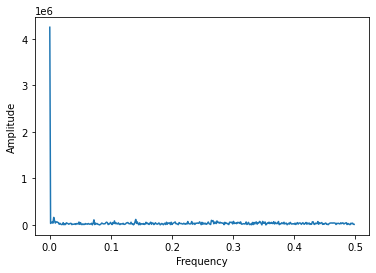

In [202]:
# Get store Type 'A'
store_df_14_sales = df[df['Store']==14]['Sales']

## getting peaks reference: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
Y = np.fft.fft(store_df_14_sales.values)

freq = np.fft.fftfreq(len(Y),1)
n = len(freq)
plt.figure()
plt.plot(freq[:int(n/2)],np.abs(Y)[:int(n/2)])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

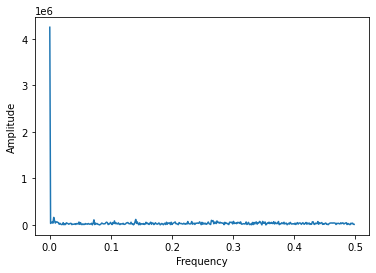

In [203]:
# Get store Type 'B'
store_df_259_sales = df[df['Store']==259]['Sales']

## getting peaks reference: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
Y = np.fft.fft(store_df_14_sales.values)

freq = np.fft.fftfreq(len(Y),1)
n = len(freq)
plt.figure()
plt.plot(freq[:int(n/2)],np.abs(Y)[:int(n/2)])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

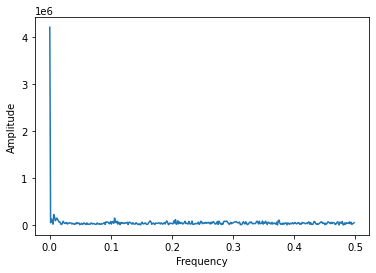

In [204]:
# Get store Type 'c'
store_df_21_sales = df[df['Store']==21]['Sales']

## getting peaks reference: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
Y = np.fft.fft(store_df_21_sales.values)

freq = np.fft.fftfreq(len(Y),1)
n = len(freq)
plt.figure()
plt.plot(freq[:int(n/2)],np.abs(Y)[:int(n/2)])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

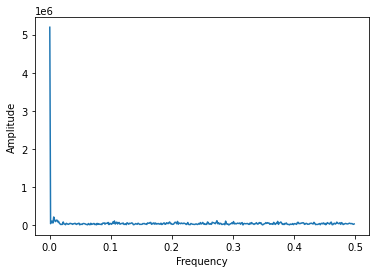

In [205]:
# Get store Type 'd'
store_df_111_sales = df[df['Store']==111]['Sales']

## getting peaks reference: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
Y = np.fft.fft(store_df_111_sales.values)

freq = np.fft.fftfreq(len(Y),1)
n = len(freq)
plt.figure()
plt.plot(freq[:int(n/2)],np.abs(Y)[:int(n/2)])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

- Observation:
    - we can see some spiked at particular frequencies.These indicates the seasinality factor
    in Sales data. We can use these 3 freq's and respective amplitudes as features ti repesent seasonality factor in 
    data

In [206]:
df = pd.read_csv('features/df_average_sales_over_promo_holiday_no_zeros',parse_dates=['Date'],
                        date_parser=mydateparse)

In [207]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'SalesLog', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'State', 'Year', 'Month', 'Day', 'WeekOfYear',
       'DayOfYear', 'holiday_this_week', 'holiday_last_week',
       'holiday_next_week', 'State_holiday_before_days',
       'State_holiday_after_days', 'Promo_before_days', 'Promo_after_days',
       'School_Holiday_before_days', 'School_Holiday_after_days',
       'SalesPerDay', 'CustomerPerDay', 'SalesPerCustomerPerDay',
       'CompetitionOpen', 'PromoOpen', 'PromoInterval0', 'PromoInterval1',
       'PromoInterval2', 'PromoInterval3', 'Variation', 'Acceleration',
       'Weekly_rolling_mean', 'Monthly_rolling_mean',
       'Previous_quarter_median', 'Previous_half_year_median',
       'Median_over_day_of_week', 'Promo_median_sales', 'Holiday_median

In [208]:
freq2_dict = dict()
freq3_dict = dict()

amp2_dict = dict()
amp3_dict = dict()

for i in tqdm(range(1,1116)):
    
    a = df[df.Store == i]
    a.sort_values("Date")
    a_sales = a['Sales']
    
    Y = np.fft.fft(a_sales.values)
    Y = abs(Y)
    freq = np.fft.fftfreq(len(Y),1)
    
    intercept_index = np.argmax(Y)
    Y = np.delete(Y,intercept_index)
    freq = np.delete(freq,intercept_index)
    
    amplitude_1_index = np.argmax(Y)
    amplitude_1 = Y[amplitude_1_index]
    Y = np.delete(Y, amplitude_1_index)
    freq_1 = freq[amplitude_1_index]
    freq = np.delete(freq, amplitude_1_index)

    amplitude_2_index = np.argmax(Y)
    amplitude_2 = Y[amplitude_2_index]
    Y = np.delete(Y, amplitude_2_index)
    freq_2 = freq[amplitude_2_index]
    freq = np.delete(freq, amplitude_2_index)

    amplitude_3_index = np.argmax(Y)
    amplitude_3 = Y[amplitude_3_index]
    Y = np.delete(Y, amplitude_3_index)
    freq_3 = freq[amplitude_3_index]
    freq = np.delete(freq, amplitude_3_index)

    a['Frequency_2'] = freq_2
    a['Frequency_3'] = freq_3

    a['Amplitude_2'] = amplitude_2
    a['Amplitude_3'] = amplitude_3
    
    freq2_dict[i] = freq_2
    freq3_dict[i] = freq_3
    
    amp2_dict[i] = amplitude_2
    amp3_dict[i] = amplitude_3
    
    if i == 1:
        k =a
    else:
        k = pd.concat([k,a])

100%|██████████████████████████████████████████████████████████████████████████████| 1115/1115 [01:41<00:00, 11.02it/s]


In [209]:
json.dump(freq2_dict, open('freq2_dict_no_zeros','w'))
json.dump(freq3_dict, open('freq3_dict_no_zeros','w'))

json.dump(amp2_dict, open('amp2_dict_no_zeros','w'))
json.dump(amp3_dict, open('amp3_dict_no_zeros','w'))

In [210]:
k.sort_values(['Year','Day'],inplace=True)
k.to_csv('features/df_fourier_no_zeros',index=False)

# Checking VIF

In [272]:
df = pd.read_csv('features/df_fourier_no_zeros',parse_dates=['Date'],date_parser=mydateparse)

In [273]:
df.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,SalesLog,StoreType,...,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Promo_median_sales,Holiday_median_sales,Frequency_2,Frequency_3,Amplitude_2,Amplitude_3
0,1,5,2013-02-01,5633,1,0,0,0,8.636575,c,...,NaN,NaN,NaN,4649.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778
1,1,5,2013-03-01,4611,1,0,0,0,8.436417,c,...,5085.666667,NaN,NaN,4649.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778
2,1,6,2013-06-01,5693,1,0,0,0,8.647168,c,...,5149.300000,NaN,NaN,4773.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778
3,1,1,2013-07-01,5614,1,1,0,0,8.633197,c,...,4773.866667,NaN,NaN,5280.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778
4,1,4,2013-08-01,4994,1,1,0,1,8.516193,c,...,4774.566667,NaN,NaN,4380.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778


In [274]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median',add_indicator=True)

In [275]:
type_assort_dict = {'a':1, 'b':2, 'c':3, 'd':4, '0':0, 0:0}

df['StoreType'] = pd.to_numeric(df['StoreType'].map(type_assort_dict))
df['Assortment'] = pd.to_numeric(df['Assortment'].map(type_assort_dict))
df['State'] = pd.to_numeric(df['State'].astype('category').cat.codes)
df['StateHoliday'] = pd.to_numeric(df['StateHoliday'].map(type_assort_dict))

In [276]:
df['Promo2SinceWeek'] = pd.to_numeric(df['Promo2SinceWeek'].fillna(-1))
df['Promo2SinceYear'] = pd.to_numeric(df['Promo2SinceYear'].fillna(-1))
df['PromoOpen']       = pd.to_numeric(df['PromoOpen'].fillna(-1))
df['PromoInterval0'] = pd.to_numeric(df['PromoInterval0'].fillna(-1))
df['PromoInterval1'] = pd.to_numeric(df['PromoInterval1'].fillna(-1))
df['PromoInterval2'] = pd.to_numeric(df['PromoInterval2'].fillna(-1))
df['PromoInterval3'] = pd.to_numeric(df['PromoInterval3'].fillna(-1))

In [277]:
df['Monthly_rolling_mean'] = pd.to_numeric(df['Monthly_rolling_mean'].fillna(df['Monthly_rolling_mean'].median()))
df['Previous_quarter_median'] = pd.to_numeric(df['Previous_quarter_median'].fillna(df['Previous_quarter_median'].median()))
df['Previous_half_year_median'] = pd.to_numeric(df['Previous_half_year_median'].fillna(df['Previous_half_year_median'].median()))

In [278]:
df['CompetitionDistance'] = pd.to_numeric(df['CompetitionDistance'].fillna(df['CompetitionDistance'].median()))
df['CompetitionOpenSinceMonth'] = pd.to_numeric(df['CompetitionOpenSinceMonth'].fillna(df['CompetitionOpenSinceMonth'].median()))
df['CompetitionOpenSinceYear'] = pd.to_numeric(df['CompetitionOpenSinceYear'].fillna(df['CompetitionOpenSinceYear'].median()))

In [279]:
df['CompetitionOpen'] = pd.to_numeric(df['CompetitionOpen'].fillna(-1))
df['Variation'] = pd.to_numeric(df['Variation'].fillna(df['Variation'].median()))
df['Acceleration'] = pd.to_numeric(df['Acceleration'].fillna(df['Acceleration'].median()))
df['Weekly_rolling_mean'] = pd.to_numeric(df['Weekly_rolling_mean'].fillna(df['Weekly_rolling_mean'].median()))

In [280]:
X = df.drop(['Date','Sales','SalesLog'],axis=1)
X.head()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Promo_median_sales,Holiday_median_sales,Frequency_2,Frequency_3,Amplitude_2,Amplitude_3
0,1,5,1,0,0,0,3,1,1270.0,9.0,...,6521.466667,6348.0,6424.0,4649.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778
1,1,5,1,0,0,0,3,1,1270.0,9.0,...,5085.666667,6348.0,6424.0,4649.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778
2,1,6,1,0,0,0,3,1,1270.0,9.0,...,5149.300000,6348.0,6424.0,4773.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778
3,1,1,1,1,0,0,3,1,1270.0,9.0,...,4773.866667,6348.0,6424.0,5280.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778
4,1,4,1,1,0,1,3,1,1270.0,9.0,...,4774.566667,6348.0,6424.0,4380.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.75778


In [281]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [282]:
#Adding constant as variance inflation factor needs a constant while calculating VIF.
X = add_constant(X)

def calculate_VIF(X):
    
    vif = pd.DataFrame()
    variables = X.columns
    vif['variables'] = variables
    vif['VIF'] = [variance_inflation_factor(X[variables].values,X.columns.get_loc(var)) for var in X.columns]
    return vif

In [283]:
for i in X.columns:
    if X[i].isnull().any():
        print(i)

holiday_last_week
holiday_next_week


In [284]:
X.dropna(inplace=True)

In [285]:
X._get_numeric_data()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Promo_median_sales,Holiday_median_sales,Frequency_2,Frequency_3,Amplitude_2,Amplitude_3
0,1,5,1,0,0,0,3,1,1270.0,9.0,...,6521.466667,6348.0,6424.0,4649.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.757780
1,1,5,1,0,0,0,3,1,1270.0,9.0,...,5085.666667,6348.0,6424.0,4649.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.757780
2,1,6,1,0,0,0,3,1,1270.0,9.0,...,5149.300000,6348.0,6424.0,4773.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.757780
3,1,1,1,1,0,0,3,1,1270.0,9.0,...,4773.866667,6348.0,6424.0,5280.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.757780
4,1,4,1,1,0,1,3,1,1270.0,9.0,...,4774.566667,6348.0,6424.0,4380.0,5199.5,4523.0,-0.006443,0.003866,137783.846537,120409.757780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837932,1113,2,1,1,0,0,1,3,9260.0,8.0,...,6498.900000,6348.0,6424.0,6379.0,7138.0,6430.5,-0.003916,-0.006527,142657.426578,123297.034156
837934,1114,6,1,0,0,0,1,3,870.0,8.0,...,19069.700000,6348.0,6424.0,21543.0,21487.5,20704.0,-0.006460,0.002584,438363.660430,333613.652702
837935,1114,2,1,1,0,0,1,3,870.0,8.0,...,20755.966667,6348.0,6424.0,19918.0,21487.5,20704.0,-0.006460,0.002584,438363.660430,333613.652702
837937,1115,6,1,0,0,0,4,3,5350.0,8.0,...,6731.466667,6348.0,6424.0,6609.5,7028.0,5867.0,0.001284,-0.006418,228954.222768,214196.009547


In [286]:
calculate_VIF(X)

,variables,VIF
0,Store,1.007814e+00
1,DayOfWeek,1.874637e+00
2,Open,1.628462e+07
3,Promo,1.966197e+01
4,StateHoliday,1.021333e+00
5,SchoolHoliday,2.497670e+00
6,StoreType,1.368620e+00
7,Assortment,1.261130e+00
8,CompetitionDistance,1.424015e+00
9,CompetitionOpenSinceMonth,1.102844e+00


In [348]:
calculate_VIF(X.drop(['Promo2','PromoInterval3','PromoInterval2','PromoInterval1','Promo2SinceYear',],axis=1))

,variables,VIF
0,Store,1.007229e+00
1,DayOfWeek,1.874440e+00
2,Open,9.420399e+06
3,Promo,1.965974e+01
4,StateHoliday,1.021333e+00
5,SchoolHoliday,2.497321e+00
6,StoreType,1.364209e+00
7,Assortment,1.261090e+00
8,CompetitionDistance,1.422264e+00
9,CompetitionOpenSinceMonth,1.100259e+00


In [372]:
calculate_VIF(X.drop(['Promo2','PromoInterval3','PromoInterval2','PromoInterval1','Promo2SinceYear','SalesPerDay'],axis=1))

,variables,VIF
0,Store,1.007229e+00
1,DayOfWeek,1.874440e+00
2,Open,9.420399e+06
3,Promo,1.965974e+01
4,StateHoliday,1.021333e+00
5,SchoolHoliday,2.497321e+00
6,StoreType,1.364209e+00
7,Assortment,1.261090e+00
8,CompetitionDistance,1.422264e+00
9,CompetitionOpenSinceMonth,1.100259e+00


In [400]:
calculate_VIF(X.drop(['Promo2','PromoInterval3','PromoInterval2','PromoInterval1','Promo2SinceYear','SalesPerDay','Open'],axis=1))

,variables,VIF
0,Store,4.042640e+00
1,DayOfWeek,9.787221e+00
2,Promo,3.535949e+01
3,StateHoliday,1.021752e+00
4,SchoolHoliday,3.055273e+00
5,StoreType,4.924828e+00
6,Assortment,6.050806e+00
7,CompetitionDistance,2.113514e+00
8,CompetitionOpenSinceMonth,9.664915e+00
9,CompetitionOpenSinceYear,1.676747e+06


In [401]:
calculate_VIF(X.drop(['Promo2','PromoInterval3','PromoInterval2','PromoInterval1','Promo2SinceYear','SalesPerDay','Open','CompetitionOpenSinceMonth'],axis=1))

,variables,VIF
0,Store,4.034850e+00
1,DayOfWeek,9.787195e+00
2,Promo,3.535905e+01
3,StateHoliday,1.021746e+00
4,SchoolHoliday,3.053566e+00
5,StoreType,4.914684e+00
6,Assortment,6.050776e+00
7,CompetitionDistance,2.099580e+00
8,CompetitionOpenSinceYear,1.555537e+06
9,Promo2SinceWeek,3.394393e+00


In [402]:
calculate_VIF(X.drop(['Promo2','PromoInterval3','PromoInterval2','PromoInterval1','Promo2SinceYear','SalesPerDay','Open','CompetitionOpenSinceMonth','DayOfWeek'],axis=1))

,variables,VIF
0,Store,4.034815e+00
1,Promo,3.482707e+01
2,StateHoliday,1.021699e+00
3,SchoolHoliday,3.015822e+00
4,StoreType,4.913056e+00
5,Assortment,6.049007e+00
6,CompetitionDistance,2.099551e+00
7,CompetitionOpenSinceYear,1.555536e+06
8,Promo2SinceWeek,3.394393e+00
9,State,4.727769e+00


- Here we can see that there are many variables which have VIF equal to infinity.This shows the presence of multi-collinearity.
- Also, there some feature with high VIF we will try to remove and then check if VIF decreases 

# Preparing the Test Data

In [435]:
# Test Data
df_test = pd.read_csv('test.csv',parse_dates=['Date'],
                     date_parser=mydateparse)

# Store Data
store_df = pd.read_csv('store.csv')

In [436]:
df_test = pd.merge(df_test,store_df,on='Store',how='left')
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


# Date Features

In [437]:
df_test['Year'] = df_test['Date'].dt.year
df_test['Month'] = df_test['Date'].dt.month
df_test['Day'] = df_test['Date'].dt.day
df_test['WeekOfYear'] = df_test['Date'].dt.year
df_test['DayOfYear'] = df_test['Date'].dt.dayofyear

# Holidays this week, last week and next week

In [438]:
import pickle
holiday_dict = pickle.load(open("Holidays_dict",'rb'))

In [439]:
for j in tqdm(df_test['Store'].unique()):
    
    a = df_test.loc[df_test['Store']== j]
    a.sort_values(['Date'],inplace=True)
    
    holidays_last_week, holidays_this_week, holidays_next_week = [ ], [ ], [ ]
    this_week_dict = dict()
    
    for i in range(len(a)):
        
        present_week = a.iloc[i]['WeekOfYear']
        present_year = a.iloc[i]['Year']
        
        df_present = a.loc[ (a['WeekOfYear']==present_week) & (a['Year']==present_year) & (a['Open']==0)]
        holidays = len(df_present)
        
        if (present_year,present_week) not in this_week_dict.keys():
            this_week_dict[(present_year,present_week)] = holidays
            
        else:
            continue
            
    for i in range(len(a)):

        present_week = a.iloc[i]['WeekOfYear']
        present_year = a.iloc[i]['Year']

        holidays_this_week.append(this_week_dict[(present_year,present_week)])

        if present_week != 1:
            past_week = present_week - 1
            past_year = present_year
        else:
            past_week = 52
            past_year = present_year - 1
        try:
            if (past_year,past_week) in this_week_dict.keys():
                holidays_last_week.append(this_week_dict[(past_year,past_week)])
            else:
                holidays_last_week.append(holidays_dict[j][(past_year,past_week)])
        except:
            holidays_last_week.append(np.nan)

        if present_week != 52:
            future_week = present_week + 1
            future_year = present_year
        else:
            future_week = 1
            future_year = present_year + 1
        try:
            holidays_next_week.append(this_week_dict[(future_year,future_week)])
        except:
            holidays_next_week.append(np.nan)

    a['holidays_this_week'] = holidays_this_week
    a['holidays_last_week'] = holidays_last_week
    a['holidays_next_week'] = holidays_next_week

    if j == 1:
        k = a
    else:
        k = pd.concat([k,a])

100%|████████████████████████████████████████████████████████████████████████████████| 856/856 [00:54<00:00, 15.72it/s]


In [440]:
df_test = k.copy()

# State Holiday Counter 

In [441]:
def State_Holiday_Counter(a):
    '''
    These function creates 2 features :  State_holiday_before_days and State_holiday_after_days
    
    '''
    a['Date'] = pd.to_datetime(a['Date'])
    a = a.sort_values("Date")
    
    list_of_store_state_holiday_before_days = [ ]
    list_of_Store_state_holiday_after_days = [ ]
    
    for j in range(len(a)):
        
        state_holiday_before_days = 0
        state_holiday_after_days  = 0
        
        #Loop to count days before a state holiday
        for l in range(j,len(a)):
            if a.iloc[l]['StateHoliday'] == '0':
                state_holiday_before_days +=1
            else:
                break
                
        list_of_store_state_holiday_before_days.append(state_holiday_before_days)
        
        #Loop to count days after a State Holiday.
        for m in range(j,0,-1):
            if a.iloc[m]['StateHoliday']=='0':
                state_holiday_after_days +=1
            else:
                break
                
        list_of_Store_state_holiday_after_days.append(state_holiday_after_days)
        
    a['State_holiday_before_days'] = list_of_store_state_holiday_before_days
    a['State_holiday_after_days']  = list_of_Store_state_holiday_after_days
    
    return a

In [442]:
list_of_individual_stores = [ ]
for i in df_test['Store'].unique():
    m = df_test.loc[df_test['Store']==i]
    list_of_individual_stores.append(m)
    
start = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:

    empty_list = []

    for i in executor.map(State_Holiday_Counter, list_of_individual_stores):
        empty_list.append(i)

print(f'Time taken is equal to {(time.time() - start)/60} minutes.')

Time taken is equal to 3.5467284083366395 minutes.


In [443]:
df_test = pd.concat(empty_list)
df_test.sort_values(['Year','Day'],inplace=True)

In [444]:
df_test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Year,Month,Day,WeekOfYear,DayOfYear,holidays_this_week,holidays_last_week,holidays_next_week,State_holiday_before_days,State_holiday_after_days
40232,40233,1,6,2015-08-01,1.0,0,0,1,c,a,...,2015,8,1,2015,213,7,NaN,NaN,48,0
13696,13697,1,2,2015-09-01,1.0,1,0,1,c,a,...,2015,9,1,2015,244,7,NaN,NaN,17,31
40233,40234,3,6,2015-08-01,1.0,0,0,0,a,a,...,2015,8,1,2015,213,7,NaN,NaN,48,0
13697,13698,3,2,2015-09-01,1.0,1,0,0,a,a,...,2015,9,1,2015,244,7,NaN,NaN,17,31
40234,40235,7,6,2015-08-01,1.0,0,0,0,a,c,...,2015,8,1,2015,213,7,NaN,NaN,48,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15403,15404,1111,1,2015-08-31,1.0,1,0,0,a,a,...,2015,8,31,2015,243,7,NaN,NaN,18,30
15404,15405,1112,1,2015-08-31,1.0,1,0,0,c,c,...,2015,8,31,2015,243,7,NaN,NaN,18,30
15405,15406,1113,1,2015-08-31,1.0,1,0,0,a,c,...,2015,8,31,2015,243,7,NaN,NaN,18,30
15406,15407,1114,1,2015-08-31,1.0,1,0,0,a,c,...,2015,8,31,2015,243,7,NaN,NaN,18,30


In [445]:
df_test = pd.concat(empty_list)
df_test.sort_values(['Year','Day'],inplace=True)

In [446]:
def promo_school_counter(df):
    
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values("Date")
    
    list_of_store_promo_before_days = [ ]
    list_of_Store_promo_after_days = [ ]
    
    list_to_store_school_holiday_before_days = [ ]
    list_to_store_school_holiday_after_days = [ ]
    
    for j in range(len(df)):
        
        before_days = 0
        after_days  = 0
        
        school_before_days = 0
        school_after_days = 0
        
        #------------------------Promo----------------------
        
        #Loop for count days before a promo
        for x in range(j,len(df)):
            if df.iloc[x]['Promo'] != 1:
                before_days += 1
            else:
                break
                
        list_of_store_promo_before_days.append(before_days)
        
        
        #Loop to count days after a Promo
        for m in range(j,0,-1):
            if df.iloc[m]['Promo'] != 1:
                after_days +=1
            else:
                break
                
        list_of_Store_promo_after_days.append(after_days)
        
        #-----------------School before and After---------------
        
        #Loop for count days before School Holiday
        for q in range(j,len(df)):
            if df.iloc[q]['SchoolHoliday'] != 1:
                school_before_days += 1
            else:
                break
                
        list_to_store_school_holiday_before_days.append(school_before_days)
        
        
        #Loop to count days after a School Holiday.
        for w in range(j,0,-1):
            if df.iloc[w]['SchoolHoliday'] != 1:
                school_after_days +=1
            else:
                break
                
        list_to_store_school_holiday_after_days.append(school_after_days)
        
        
    df['Promo_before_days'] = list_of_store_promo_before_days
    df['Promo_after_days'] = list_of_Store_promo_after_days
    
    df['School_Holiday_before_days'] = list_to_store_school_holiday_before_days
    df['School_Holiday_after_days'] = list_to_store_school_holiday_after_days
    
    return df    

In [447]:
list_of_individual_store_dataframes = []

for i in range(1,1116):
    m = df_test.loc[df_test['Store']==i]
    list_of_individual_store_dataframes.append(m)

start = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:

    empty_list = []

    for i in executor.map(promo_school_counter, list_of_individual_store_dataframes):
        empty_list.append(i)

print(f'Time taken is equal to {(time.time() - start)/60} minutes.') 

Time taken is equal to 1.8289022167523703 minutes.


In [448]:
df_test = pd.concat(empty_list)
df_test.sort_values(['Year','Day'],inplace=True)

# Sales per day, customer per day and Sales_per_customers_per_day

In [449]:
sales_per_day_dict = json.load(open('features/sales_per_day_dict_no_zeros','r'))
customers_per_day_dict = json.load(open('features/customers_per_day_dict_no_zeros','r'))
sales_per_customers_per_day_dict = json.load(open('features/sales_per_customers_per_day_dict_no_zeros','r'))

#Adding features to the test dataframe.
df_test['Sales_per_day'] = df_test['Store'].apply(lambda x: sales_per_day_dict[str(x)])
df_test['Customers_per_day'] = df_test['Store'].apply(lambda x: customers_per_day_dict[str(x)])
df_test['Sales_Per_Customers_Per_Day'] = df_test['Store'].apply(lambda x: sales_per_customers_per_day_dict[str(x)])

# Competition Open and Promo Open

In [450]:
# Convert Competition to Months
df_test['CompetitionOpen'] = 12 * (df_test['Year']- df_test['CompetitionOpenSinceYear']) + (df_test['Month'] - df_test['CompetitionOpenSinceMonth'])
df_test['CompetitionOpen'] = df_test['CompetitionOpen'].fillna(-1)
# Convert Promo open to months
df_test['PromoOpen'] = 12 * (df_test['Year']- df_test['Promo2SinceYear']) + (df_test['WeekOfYear'] - df_test['Promo2SinceWeek']) /4.0
df_test['PromoOpen'] = df_test['PromoOpen'].fillna(-1)

In [451]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,State_holiday_after_days,Promo_before_days,Promo_after_days,School_Holiday_before_days,School_Holiday_after_days,Sales_per_day,Customers_per_day,Sales_Per_Customers_Per_Day,CompetitionOpen,PromoOpen
40232,40233,1,6,2015-08-01,1.0,0,0,1,c,a,...,0,2.0,0.0,0.0,0.0,4759.096031,564.049936,8.437366,83.0,-1.00
13696,13697,1,2,2015-09-01,1.0,1,0,1,c,a,...,31,0.0,0.0,0.0,0.0,4759.096031,564.049936,8.437366,84.0,-1.00
40233,40234,3,6,2015-08-01,1.0,0,0,0,a,a,...,0,2.0,0.0,2.0,0.0,6942.568678,750.077022,9.255808,104.0,548.25
13697,13698,3,2,2015-09-01,1.0,1,0,0,a,a,...,31,0.0,0.0,17.0,21.0,6942.568678,750.077022,9.255808,105.0,548.25
40234,40235,7,6,2015-08-01,1.0,0,0,0,a,c,...,0,2.0,0.0,2.0,0.0,8817.050891,948.561069,9.295185,28.0,-1.00


# Promointerval Features

In [452]:
#Splitting PromoInterval into parts. For ex: (Jan,March,May) --> (Jan), (March), (May).
s = df_test['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
df_test = df_test.join(s)

#Converting Promointerval columns to numerical.
month_to_num_dict = {
                    'Jan' : 1,
                    'Feb' : 2,
                    'Mar' : 3,
                    'Apr' : 4,
                    'May' : 5,
                    'Jun' : 6,
                    'Jul' : 7,
                    'Aug' : 8,
                    'Sept' : 9, 
                    'Oct' : 10,
                    'Nov' : 11,
                    'Dec' : 12,
                    'nan' : np.NaN
                    }

df_test['PromoInterval0'] = df_test['PromoInterval0'].map(month_to_num_dict)
df_test['PromoInterval1'] = df_test['PromoInterval1'].map(month_to_num_dict)
df_test['PromoInterval2'] = df_test['PromoInterval2'].map(month_to_num_dict)
df_test['PromoInterval3'] = df_test['PromoInterval3'].map(month_to_num_dict)

#Removing PromoInterval feature as no further use now.
del df_test['PromoInterval']

# Variation and Acceleration in Sales

In [453]:
variation_dict = json.load(open('features/vairation_dict_no_zeros','rb'))
acceleration_dict = json.load(open('features/acceleration_dict_no_zeros','rb'))
weekly_rolling_mean_dict = json.load(open('features/weekly_rolling_dict_no_zeros','rb'))
monthly_rolling_mean_dict = json.load(open('features/monthly_rolling_dict_no_zeros','rb'))

df_test['Variation'] = df_test['Store'].apply(lambda x: variation_dict[str(x)])
df_test['Acceleration'] = df_test['Store'].apply(lambda x: acceleration_dict[str(x)])
df_test['Weekly_rolling_mean'] = df_test['Store'].apply(lambda x: weekly_rolling_mean_dict[str(x)])
df_test['Monthly_rolling_mean'] = df_test['Store'].apply(lambda x: monthly_rolling_mean_dict[str(x)])

# Previous Quarter Sales and Past 6 months Sales

In [454]:
pervious_quarter = json.load(open('features/previous_quarter_dict_no_zero','rb'))
previous_half_year = json.load(open('features/previous_half_year_dict_no_zero','rb'))

df_test['Previous_quarter_median'] = df_test['Store'].apply(lambda x: pervious_quarter[str(x)])
df_test['Previous_half_year_median'] = df_test['Store'].apply(lambda x: previous_half_year[str(x)])

In [455]:
def median_over_day_of_week(x:dict, store:int, day:int):

    y = x.get(str(store))
    z = day    
    return float(z)

day_of_week_store_dict = json.load(open('features/day_of_week_store_dict_no_zeros','r'))

empty_list = []

for i in range(len(df_test)):

    store = df_test.iloc[i]['Store']
    day_of_week = df_test.iloc[i]['DayOfWeek']
    empty_list.append(median_over_day_of_week(day_of_week_store_dict, store,day_of_week))
    
df_test['Median_over_day_of_week'] = empty_list


# Fourier Features 


In [456]:
freq2_dict = json.load(open('freq2_dict_no_zeros','r'))
freq3_dict = json.load(open('freq3_dict_no_zeros','r'))

amp2_dict = json.load(open('amp2_dict_no_zeros','r'))
amp3_dict = json.load(open('amp3_dict_no_zeros','r'))

In [457]:
df_test['Frequency_2'] = df_test['Store'].apply(lambda x: freq2_dict[str(x)])
df_test['Frequency_3'] = df_test['Store'].apply(lambda x: freq3_dict[str(x)])
df_test['Amplitude_2'] = df_test['Store'].apply(lambda x: amp2_dict[str(x)])
df_test['Amplitude_3'] = df_test['Store'].apply(lambda x: amp3_dict[str(x)])

In [458]:
df_test['Promo2SinceWeek'] = df_test['Promo2SinceWeek'].fillna(-1)
df_test['Promo2SinceYear'] = df_test['Promo2SinceYear'].fillna(-1)

df_test['PromoInterval0'] = df_test["PromoInterval0"].fillna(-1)
df_test['Open'] = df_test['Open'].fillna(0)
df_test['Median_over_day_week'] = df_test['Median_over_day_of_week'].fillna(0)

In [459]:
del df_test['Date']

In [460]:
df_test.to_csv('df_test_with_no_zeros',index=False)

In [461]:
df_test

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,Weekly_rolling_mean,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Frequency_2,Frequency_3,Amplitude_2,Amplitude_3,Median_over_day_week
40232,40233,1,6,1.0,0,0,1,c,a,1270.0,...,4608.642857,4602.666667,4711.811594,4697.808081,6.0,-0.006443,0.003866,137783.846537,120409.757780,6.0
13696,13697,1,2,1.0,1,0,1,c,a,1270.0,...,4608.642857,4602.666667,4711.811594,4697.808081,2.0,-0.006443,0.003866,137783.846537,120409.757780,2.0
40233,40234,3,6,1.0,0,0,0,a,a,14130.0,...,6907.428571,6829.866667,6736.178977,6644.895238,6.0,-0.006427,0.307198,298090.852083,163328.316557,6.0
13697,13698,3,2,1.0,1,0,0,a,a,14130.0,...,6907.428571,6829.866667,6736.178977,6644.895238,2.0,-0.006427,0.307198,298090.852083,163328.316557,2.0
40234,40235,7,6,1.0,0,0,0,a,c,24000.0,...,8610.857143,8714.916667,8649.511111,8509.115741,6.0,-0.006386,0.268199,290645.894025,196079.200925,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15403,15404,1111,1,1.0,1,0,0,a,a,1900.0,...,5239.571429,5251.666667,5113.063401,5074.228155,1.0,-0.006452,-0.001290,156663.360475,126246.879825,1.0
15404,15405,1112,1,1.0,1,0,0,c,c,1880.0,...,9925.000000,9885.350000,9615.915625,9380.380435,1.0,-0.001311,0.006553,383252.774468,326756.022702,1.0
15405,15406,1113,1,1.0,1,0,0,a,c,9260.0,...,6432.000000,6436.133333,6437.477204,6366.228261,1.0,-0.003916,-0.006527,142657.426578,123297.034156,1.0
15406,15407,1114,1,1.0,1,0,0,a,c,870.0,...,20337.071429,20453.666667,20397.827485,20182.287129,1.0,-0.006460,0.002584,438363.660430,333613.652702,1.0
